# <u>Penguins!: An Exploration and Classification of Species </u>
## <br> Author: Christopher W. Smith </br>
<br>Unfinished, Updated:10/05/2020 </br>

<br> <i>linkdin</i>: www.linkedin.com/in/christopher-w-smith022 </br>

<br> The purpose of this notebook is to perform an exploratory data analysis (EDA) on the data set from: Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081.<doi:10.1371/journal.pone.0090081>. After, data preprocessing was performed looking at feature-engineering of selected features by ANOVA F-ratio. Then dimensionality reduction was done by princicipal component analysis (PCA) to reduce the number of features in the data set. Lastly, support vector machines (SVM) was used with hyper parameterization by grid and randomized searchers for the most accurately built models. </br>

Kaggle link: https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data

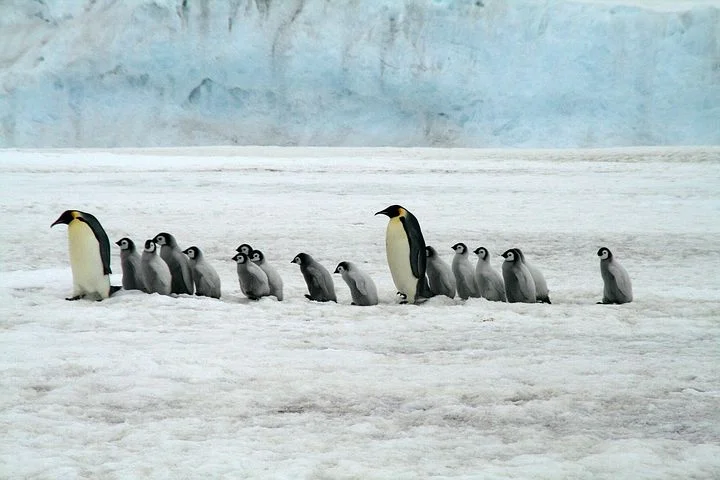

# Initial Relevant Packages
Libraries to be used primarily for loading the data, cleaning, and EDA.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting Functions
import matplotlib.pyplot as plt

#Aesthetics
import seaborn as sns
sns.set_style('ticks')

#Data Import
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Loading the Data

In [ ]:
lter=pd.read_csv('/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_lter.csv')
size=pd.read_csv('/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv')

In [ ]:
print('***lter file:')
lter.info()
print('----'*10)
print('***size file:')
size.info()

We will specifically work with the lter file as there are more features to analyze and provides more features to select from. We see that there are some null values that will have to be filled in. The data cleaning will be performed below.

# Meaning To Each Feature
- species: penguin species (Chinstrap, Adélie, or Gentoo)
- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
- sex: penguin gender
- Delta 15 N (o/oo)- ratio of isotope ($^{15}$N)
- Delta 13 C (o/oo)- ratio of isotope ($^{13}$C)

Printing the column names and categorical classifiers will help make things faster by simple copy and paste. Similarly, by printing the columns we can check to make sure there is no extra spaccings in the titles when writing out the code later. Displaying the first few rows of the data frame allows us to get a quick look of what we are looking at.

In [ ]:
print(lter.columns)
print(lter['Species'].unique())
lter.head()

# Cleaning The Data
Simply, the data will be cleaned and abbreviated to make it easier to view. The species names can be abbreviated which will look better for plotting. The features for prediction will have the null values relaced by either the mean or the mode by group. 

In [ ]:
new_lter=lter.copy()

new_lter['Species']=new_lter['Species'].replace({'Adelie Penguin (Pygoscelis adeliae)':'P.adeliae',
                                                 'Chinstrap penguin (Pygoscelis antarctica)':'P.antartica',
                                               'Gentoo penguin (Pygoscelis papua)':'P.papua'}) # Abbreviating the names

new_lter['Sex'].fillna('.', inplace=True)#First replace the null value with a '.' as part of that column contains them already
new_lter['Sex']=new_lter['Sex'].replace({'MALE':'male','FEMALE':'female'})#replacing uppercases with lower cases
new_lter['Sex']=new_lter['Sex'].replace({'.':new_lter['Sex'].mode()[0]})#By running this a second time with the space, it will take the mode of sex

new_lter['Culmen Length (mm)'].fillna(new_lter.groupby('Species')['Culmen Length (mm)'].transform('mean'),inplace=True)

new_lter['Culmen Depth (mm)'].fillna(new_lter.groupby('Species')['Culmen Depth (mm)'].transform('mean'),inplace=True)

new_lter['Flipper Length (mm)'].fillna(new_lter.groupby('Species')['Flipper Length (mm)'].transform('mean'),inplace=True)

new_lter['Body Mass (g)'].fillna(new_lter.groupby('Species')['Body Mass (g)'].transform('mean'),inplace=True)

new_lter['Delta 15 N (o/oo)'].fillna(new_lter.groupby('Species')['Delta 15 N (o/oo)'].transform('mean'),inplace=True)

new_lter['Delta 13 C (o/oo)'].fillna(new_lter.groupby('Species')['Delta 13 C (o/oo)'].transform('mean'),inplace=True)

new_lter['Body Mass (kg)']=new_lter['Body Mass (g)']/1000 #Conversion to kilograms

new_lter=new_lter.drop(['Body Mass (g)','studyName','Sample Number','Comments','Individual ID'], axis=1)
#We will not need these columns as they will not contribute to classification.

print(new_lter.info())#Lets check to make sure all NaN is gone
new_lter.head()#Visualize the table to confirm the changes we wanted

Now that the data is clean, lets take a look at what values exist in the non-predicting categorical columns.

In [ ]:
#Observing Categorical Values
print('Region', new_lter['Region'].unique())
print('Island', new_lter['Island'].unique())
print('Stage', new_lter['Stage'].unique())
print('Clutch', new_lter['Clutch Completion'].unique())

We see that both Region and Stage have only a single value and will not be useful for ML just by obsersvation. Therefore, we will drop those two prior to EDA.

In [ ]:
new_lter=new_lter.drop(['Region', 'Stage', 'Date Egg'], axis=1)
new_lter.head()

## EDA
Before building a model, it is good practice to first explore the data for to find meaningful relationships. By exploring first, we can draw conclusions for why certain features may or may not be important later. First, we will simply count the total number of species by sex.

In [ ]:
fig, ax=plt.subplots()

sns.countplot(data=new_lter, x='Species', hue='Sex', palette=['darkblue','darkred'])


#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Species', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Species Count.png')

<b> Clearly, we have a higher count of P.adeliae than P.antartica which means when we move to machine learning later we may run into bias of our learning algorithm. Next, lets look at islands in which the species reside.

In [ ]:
fig, ax=plt.subplots()

sns.countplot(data=new_lter, x='Island', hue='Species', palette=['darkblue','darkred','darkgreen'])


#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Island', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Island.png')

Intrestingly, P.antartica and P.papua are each found only on a specific island. This will assist in developing a model later. Next, the categorical variables within clutch completion can be counted as well.

In [ ]:
fig, ax=plt.subplots()

sns.countplot(data=new_lter, x='Clutch Completion', hue='Species', palette=['darkblue','darkred', 'darkgreen'])


#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Clutch Completion', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Clutch.png')

Given a majority from each species has clutch completion, this may be a bad variable to use later on as it doesnt offer much distinction. Looking further, maybe the culmen will vary.

In [ ]:
fig, ax=plt.subplots()

sns.scatterplot(data=new_lter, x='Culmen Length (mm)',y='Culmen Depth (mm)', hue='Species', palette=['b','r','g'], s=30)


#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Culmen Length (mm)', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Culmen Depth (mm)', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Culmen.png')

We have some separation of species when observing the culmen length and the culmen depth, where the size ranges are more reserved to specific species. Do we see this same kind of separation for flipper length as well?

In [ ]:
color=['darkblue','darkred','darkgreen']
sns.FacetGrid(data=new_lter, hue="Species", height=6, palette=color)\
    .map(sns.kdeplot, "Flipper Length (mm)", lw=2) 

#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)

plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Flipper Length (mm)', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='k')
plt.legend(fontsize='large',prop={'weight':'bold'})

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Flipper.png')

plt.show()


By species, there is a positive trend towards average flipper length by species. Similarly, we would expect that a bigger size flipper may indicate that P.papua will weigh more than the other two species.

In [ ]:
fig, ax=plt.subplots()

sns.boxplot(data=new_lter, x='Species', y='Body Mass (kg)', palette=color)
#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Species', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Body Mass (kg)', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Species Mass.png')

Indeed, we do see that P.papua does weigh more than the other two species. 

In [ ]:
fig, ax=plt.subplots()
sns.boxplot(data=new_lter, x='Species', y='Body Mass (kg)',hue='Sex', palette=color)

#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('Species', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Body Mass (kg)', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Gender Mass.png')

We can further observe that generally, that the trend between all three species is that males weigh more. How about the elemental isotopic ratios?

In [ ]:
fig, ax=plt.subplots()

sns.scatterplot(data=new_lter, x='Delta 15 N (o/oo)',y='Delta 13 C (o/oo)', hue='Species', palette=color, s=30)


#Ticks
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold')


#Labels
plt.xlabel('N-15', fontsize=12, fontweight='bold', color='k')
plt.ylabel('C-13', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Isotope ratios.png')

Again we see a general separation using the isotopic ratios for both N and C. Below we can summarize the general findings of our results by the pairplot.

In [ ]:
sns.pairplot(new_lter, hue='Species', palette=color)
plt.savefig('pairplot.png')

Laslty, we can summarize our EDA with this pairplot showing some of the separations we observed above between species. Similarly, this shows basic separation possibilities in different comparisons of our numerical variables. Next we will begin preprocessing for ML.

# Label Encoding and Feature Selection

## Label Encoding
Using label encoding will allow the conversion of categorical values to be changed to ordinal per column which can be then used for feature selection by correlation matrix. However, note that none of these variables are not truly ordinal and if selected will be converted to a One Hot Encoding (OHE) scheme as that is more appropriate for categorical data.

In [ ]:
from sklearn import preprocessing 
LE=preprocessing.LabelEncoder()

In [ ]:
lter_encode=new_lter.copy()
lter_encode['Island']=LE.fit_transform(lter_encode['Island'])
lter_encode['Clutch Completion']=LE.fit_transform(lter_encode['Clutch Completion'])
lter_encode['Sex']=LE.fit_transform(lter_encode['Sex'])
lter_encode['Species_Code']=LE.fit_transform(lter_encode['Species']) #This will be used for a correlation matrix
lter_encode.head()

## Feature Selection

Before building models, it is good practice to remove features that may be unneccessary. We can do this using the SelectKBest function in the sklearn package. This will give us a score of importance by ANOVA F-ratios. The higher the ratio the more important the feature will be.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
#Feature Selection
X=lter_encode.drop(['Species', 'Species_Code'], axis=1)
Y=lter_encode['Species']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print 10 best features

In [ ]:
###Sets for full aesthetics of pots
fig, ax = plt.subplots(figsize=(7,7))


#Setting seaborn plot
bar=sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis',linewidth=0.5, saturation=2, orient='h')

#Setting tick parameters 
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold')

#Labels
plt.xlabel('Importance Score', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Feature', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('feature selection.png')

The two least important features as shown on the bar plot above are Clutch Completion and Sex. We can further verify and compare this by looking at a correlation matrix which considers a pearson (linear) correlation coefficient.

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(lter_encode.corr(),annot=True, linewidths=0.1)
plt.xticks(fontsize=12, fontweight='bold', rotation=90)
plt.yticks(fontsize=12, fontweight='bold')

plt.savefig('correlation matrix.png')
plt.show()

Again, we can observe that both Sex and Clutch Completion have almost no correlation to species. Therfore, they will be dropped along with species code as that will no longer be needed either.

In [ ]:
lter_encode_drop=lter_encode.copy()
lter_encode_drop=lter_encode_drop.drop(['Sex','Clutch Completion','Species_Code'], axis=1)
lter_encode_drop.head()

# One Hot Encoding
Next we will expand our categorical feature, Island, in a One-Hot encoding format to expand the data by cateogrical values. Given Island is the only one that is categorical for prediction we will use OHE on that.

In [ ]:
OHE=preprocessing.OneHotEncoder()
lter_ohe=lter_encode_drop.copy()

lter_code=OHE.fit_transform(lter_ohe[['Island']]).toarray()

lter_list=list(sorted(new_lter['Island'].unique()))  #Will name the column values to the respective Island

lter_code=pd.DataFrame(lter_code, columns=lter_list)#Setting OHE dataframe for merge
lter_ohe=pd.concat([lter_code,lter_ohe], axis=1)#Merging Data Frames

lter_ohe.head()

As seen above, One Hot Encoding creates a dummy variable scheme that allows for a yes no approach in multiple columns. The data is expanded and can now be further preprocessed by scaling. First, Island will be dropped as it is no longer needed.

In [ ]:
lter_ohe=lter_ohe.drop(['Island'], axis=1)
lter_ohe.head()

# Splitting the Data 
First, the data will be split so we can train a scaler model to apply to an unknwon (test) data set. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(lter_ohe.drop(['Species'], axis=1), lter_ohe['Species'],test_size=0.25, random_state=0)

print("X_train shape :",X_train.shape)
print("Y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",y_test.shape)

# Scaling Preprocessing
Next, the data will be scaled by the standard scaler function in the sklearn package using the formula $z=\frac{X_{o}-\mu}{\sigma}$. This can help reduce the effect of outliers when modeling later.

In [ ]:
scaler=preprocessing.StandardScaler()

X_train_scaled=scaler.fit_transform(X_train) #Scaling and fitting the training set to a model
X_test_scaled=scaler.transform(X_test) #Transformation of testing set based off of trained scaler model

# Dimensionality Reduction With PCA
PCA is a linear dimensionality reduction technique that computationally will reduce the data and separate it in an unsupervised manner by maximal variance. We will apply it to our data and see how it fits.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_scaled)
print('Ratios:',pca.explained_variance_ratio_*100)#Ratio per component.

In [ ]:
num_com=np.arange(1,(len(pca.explained_variance_ratio_)+1),1)
# The number of components to plot, the +1 is because np.arange cuts the number off at 1 minus endpoint value.

ratio=np.cumsum(pca.explained_variance_ratio_*100) #Setting the raios into a variable

fig, ax = plt.subplots(figsize=(5,5))

sns.lineplot(x=num_com, y=ratio, color='k', linewidth=3)

#Tick parameters
ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

ax.axhline(90, linestyle='--', color='k') # horizontal lines

#Labels
plt.xlabel('number of components', fontsize=12, fontweight='bold', color='k')
plt.ylabel('cumulative explained variance (%)', fontsize=12, fontweight='bold', color='k')

#Removing Spines and setting up remianing
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('PCA.png')

At around ~4-5 components there is an accumulation of 90% explained variance. We will select 5 components as four is just <90%. 

In [ ]:
n=5 #Number of components
pca=PCA(n_components=n)

X_train_pca=pca.fit_transform(X_train_scaled)# Fitting and transforming the training data
X_test_pca=pca.transform(X_test_scaled)# Transforming the test data by the fitted trained PCA()

# Machine Learning with SVM and Grid/Randomization Search
For modeling we will use the support vector machines classifiers (SVC). The SVC's can handle higher dimensional data and genearte hyperplanes for separation and score on a yes (1) no (1) basis. The rulings are decided for where a data point lands within a decision boundary. We can evalute multiple parameters at one using Grid or Randomization Search functions. Grid Search evalutes several input parameters at all combinations input while randomized search looks for the best. Cross-validation is the models self assemessment when trying to find the best parameters on the training data and can be done in "n" amount of replicates.

In [ ]:
from sklearn.svm import SVC #Classifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV #Paramterizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Accuracy metrics
import itertools #Used for iterations

## Grid Search Function

In [ ]:
def Searcher(estimator, param_grid, search, train_x, train_y):
    """
    This is a helper function for tuning hyperparameters using the two search methods.
    Methods must be GridSearchCV or RandomizedSearchCV.
    Inputs:
        estimator: Any Classifier
        param_grid: Range of parameters to search
        search: Grid search or Randomized search
        train_x: input variable of your X_train variables 
        train_y: input variable of your y_train variables
    Output:
        Returns the estimator instance, clf
        
    Modified from: https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random#To-standardize-or-not-to-standardize
    
    """   
    try:
        if search == "grid":
            clf = GridSearchCV(
                estimator=estimator, 
                param_grid=param_grid, 
                scoring=None,
                n_jobs=-1, 
                cv=10, #Cross-validation at 10 replicates
                verbose=0,
                return_train_score=True
            )
        elif search == "random":           
            clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=10,
                verbose=0,
                random_state=1,
                return_train_score=True
            )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0)
        
    # Fit the model
    clf.fit(X=train_x, y=train_y)

    return clf

## Confusion Matrix Function 
(Read red indents below def function for understanding of code)

In [ ]:
def plot_confusion_matrix(cm, title,label):
    """
    Plot for Confusion Matrix:
    Inputs:
        cm: sklearn confusion_matrix function for y_true and y_pred as seen in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        title: title of confusion matrix as a 'string'
        label: the unique label that represents classes for prediction can be done as sorted(dataframe['labels'].unique()).
    """
    classes=sorted(label)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")   

## Modeling

In [ ]:
#Grid Search SVM Parameters
svm_param = {
    "C": [.01, .1, 1, 5, 10, 100], #Specific parameters to be tested at all combinations
    "gamma": [0, .01, .1, 1, 5, 10, 100],
    "kernel": ["rbf","linear""poly"],
    "random_state": [1]}

#Randomized Grid Search SVM Parameters
svm_dist = {
    "C": np.arange(0.01,2, 0.01),   #By using np.arange it will select from randomized values
    "gamma": np.arange(0,1, 0.01),
    "kernel": ["rbf","linear""poly"],
    "random_state": [1]}

"""
Following the code above, we can set the parameters for both grid search and randomized search. The grid search will evaluate all specified 
parameters while the randomized search will look at the parameters labeled in random order at the best training accuracy. The np.arange function
allows for a multitude of points to be looked at between the set start and end values of 0.01 to 2. """

#Grid Search
svm_grid = Searcher(SVC(), svm_param, "grid", X_train_pca, y_train) #Searcher(clf, param_grid, searcher,train_x, train_y)
acc = accuracy_score(y_true=y_test, y_pred=svm_grid.predict(X_test_pca))
cfmatrix_grid = confusion_matrix(y_true=y_test, y_pred=svm_grid.predict(X_test_pca))#Setting Grid Search Confusion Matrix Function

#Defining prints for accuracy metrics of grid
print("**Grid search results**")
print("The best parameters are:",svm_grid.best_params_)
print("Best training accuracy:\t", svm_grid.best_score_)
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=svm_grid.predict(X_test_pca)))

print('----'*20)

#Randomized Grid Search
svm_random = Searcher(SVC(), svm_dist, "random", X_train_pca, y_train) #Searcher(clf, param_grid, searcher,train_x, train_y)
acc = accuracy_score(y_true=y_test, y_pred=svm_random.predict(X_test_pca))
cfmatrix_rand = confusion_matrix(y_true=y_test, y_pred=svm_random.predict(X_test_pca))#Setting Grid Search Confusion Matrix Function

#Defining prints for accuracy metrics of randomized
print("**Random search results**")
print("The best parameters are:",svm_random.best_params_)
print("Best training accuracy:\t", svm_random.best_score_)
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=svm_random.predict(X_test_pca)))

#Plotting the confusion matrices
plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title='Random Search Confusion Matrix',label=lter_ohe['Species'].unique()) #grid matrix
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title='Grid Search Confusion Matrix', label=lter_ohe['Species'].unique()) #randomized matrix

plt.savefig('confusion.png')

As we can see both searches provided 100% accuracy. Similarly, using the metric of an f1-score there was 100% accuracy showing that the model is very well built. 

# Conclusion
We observed that:
* Many features have some prominent separation alone for distincting the penguin species.
* Using KBestSelection we were able to use the most important features from the data set
* 5 dimensions from PCA provided ~90% of cumulative data variance which:
* Contributed enough variability to the data set to score 100% prediction accuracy towards the testing data set as shown with SVM using Grid/Randomized Searches.

# Next Steps
* So far a model was build to specifically classify penguins by species. 
* Now that model is established and shown to be highly accurate, I want to build submodels now to classify individuals within species by specific Sex. 
* Through EDA we observed that there is a minor difference between males and females when observed body mass (kg).
* Through Feature Selection it was determined that Sex is not a good predictor for species, so maybe it can be turned backaround and be used as a classifier.
* A limitation that I see to using this as classifier however, was that we had to clean the Sex column and input some categorical values by mode and it may not be as accurate or correct to model this way.

<b>Suggestions?

If you stuck around to the end please leave a comment for feedback or upvote!</b>

Like what I have done? Check out my other notebooks here: https://www.kaggle.com/christopherwsmith